# 📈 Professional Bitcoin Directional Prediction using SVM
## Optimized for hourly BTC/USDT analysis

This notebook implements a state-of-the-art directional trading model using **Support Vector Machines (SVM)**.

### Objectives:
1. **Information Extraction**: Process 52 indicators (Technical, On-Chain, Macro, Sentiment).
2. **Dimensionality Reduction**: Identify the top Alpha generators using univariate statistical tests and correlation filters.
3. **Optimization**: Fine-tune the SVM hyperparameters through Time-Series aware cross-validation.
4. **Performance Evaluation**: Analyze the strategy returns through financial risk metrics (Sharpe, Drawdown).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import SVC
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')


# ==============================
# File Path (Local)
# ==============================
FILE_PATH = "../data/features/btc_features_complete.csv"

# ==============================
# Save Model & Scaler
# ==============================
os.makedirs('../models/svm', exist_ok=True)
MODEL_SAVE_PATH = "../models/svm/best_svm_model.pkl"
SCALER_SAVE_PATH = "../models/svm/best_scaler_svm.pkl"

# ==============================
# Styling (dark + crypto)
# ==============================
plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (16, 9)

# 🎯 Crypto Palette
COLORS = ['#F7931A', '#00FF9C', '#FF4C4C']

# ==============================
# Data Loading
# ==============================
df = pd.read_csv(FILE_PATH)

print(df.head())
print(df.info())
print("Shape:", df.shape)

              Datetime      Open      High      Low     Close       Volume  \
0  2018-01-31 01:00:00   9829.99  10080.00  9700.00   9967.48  2341.104910   
1  2018-01-31 02:00:00   9967.47  10278.00  9932.46  10229.84  1162.774900   
2  2018-01-31 03:00:00  10229.77  10233.99  9967.00  10060.00   920.236009   
3  2018-01-31 04:00:00  10069.96  10089.59  9888.00   9983.76   682.356001   
4  2018-01-31 05:00:00   9985.00  10177.99  9810.00  10097.25  1008.606525   

    returns  log_returns  future_return_1h  future_return_6h  ...  nvt_ratio  \
0  0.013987     0.013890          0.026322          0.031354  ...   0.830917   
1  0.026322     0.025981         -0.016602          0.000960  ...   0.830917   
2 -0.016602    -0.016742         -0.007579          0.012971  ...   0.830917   
3 -0.007579    -0.007607          0.011367          0.028116  ...   0.830917   
4  0.011367     0.011303          0.014610          0.019094  ...   0.830917   

   fg_change_7d  extreme_fear  extreme_greed  sp50

---
## 1. Data Ingestion & Sequence Engineering
We use the comprehensive dataset generated by our production pipeline, focusing on numeric inputs.

In [2]:
def load_and_preprocess(path):
    df = pd.read_csv(path, index_col=0, parse_dates=True)
    # Professional Rule: Automatically select only numeric columns for model inputs
    # This avoids errors with categorical labels like 'Fear' or 'Greed'
    df = df.select_dtypes(include=[np.number])
    print(f"Initial numeric dataset shape: {df.shape}")
    # Engineering lags for the top technical indicators
    # We focus on Momentum and RSI dynamics
    target_lags = ['returns', 'RSI_14', 'MACD', 'MACD_hist', 'Close', 'Volume']
    existing_lags = [f for f in target_lags if f in df.columns]
    for f in existing_lags:
        for lag in range(1, 6):
            df[f"{f}_lag_{lag}"] = df[f].shift(lag)
    return df.ffill().bfill().dropna()

df = load_and_preprocess(FILE_PATH)
print(f"Processing complete. Total features (with lags): {len(df.columns)}")


Initial numeric dataset shape: (69861, 69)
Processing complete. Total features (with lags): 99


---
## 2. Advanced Feature Selection
Selecting variables that have the highest ANOVA F-value relative to the direction and filtering out highly correlated features.

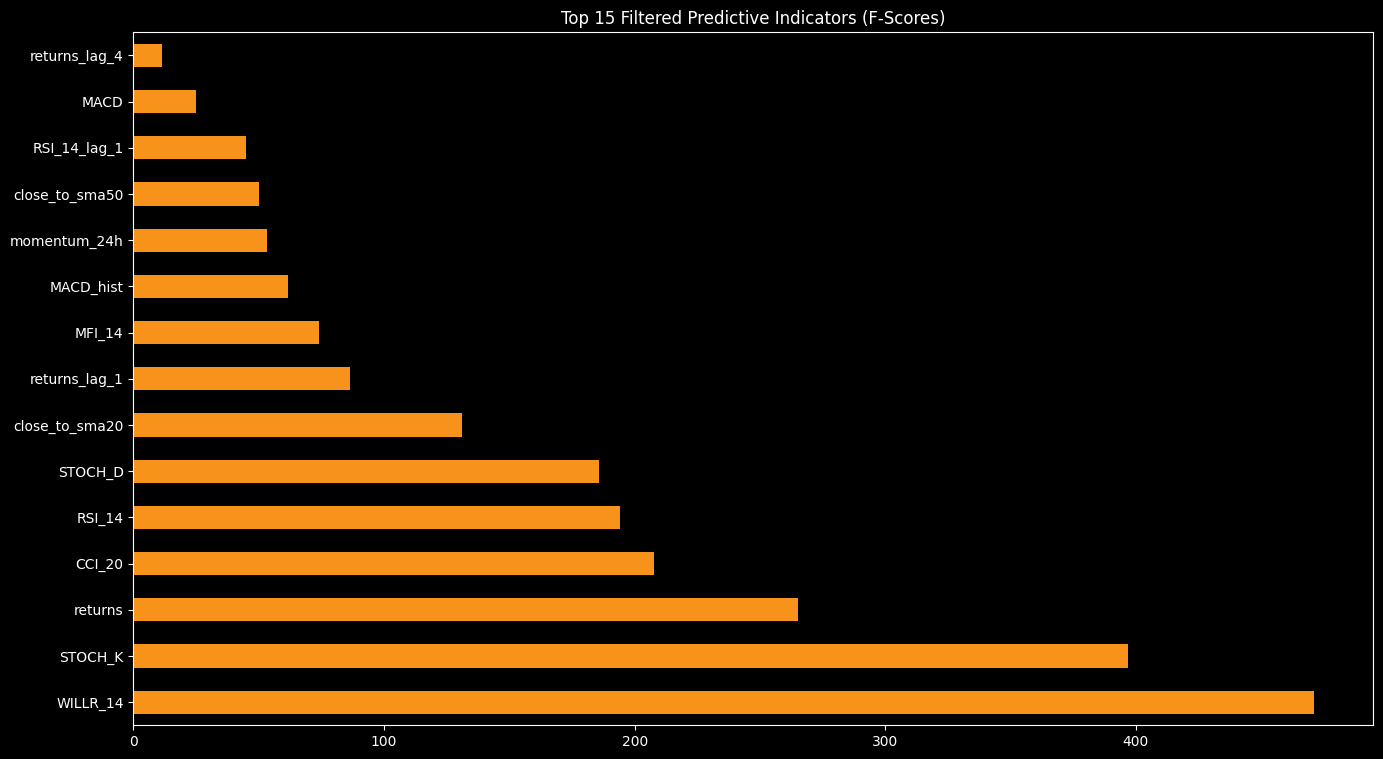

Selected Top 25: ['Open', 'returns', 'momentum_24h', 'MACD', 'MACD_hist']...


In [3]:
def select_features(df, k=35):
    target = 'target_direction'
    X_raw = df.drop([c for c in df.columns if 'target' in c.lower() or 'future' in c.lower()], axis=1)
    y = df[target]
    # Univariate selection
    selector = SelectKBest(score_func=f_classif, k=min(k*2, X_raw.shape[1]))
    selector.fit(X_raw, y)
    top_raw_cols = X_raw.columns[selector.get_support()]
    # Multicollinearity Filter: Keep only one feature from highly correlated pairs
    corr_matrix = X_raw[top_raw_cols].corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
    final_cols = [c for c in top_raw_cols if c not in to_drop][:k]
    # Visualization of feature importance
    scores = pd.Series(selector.scores_, index=X_raw.columns).loc[final_cols].sort_values(ascending=False).head(15)
    scores.plot(kind='barh', color=COLORS[0])
    plt.title('Top 15 Filtered Predictive Indicators (F-Scores)')
    plt.show()
    return final_cols

top_features = select_features(df, k=35)
print(f"Selected Top 25: {top_features[:5]}...")


---
## 3. High-Performance Model Training
We use `TimeSeriesSplit` to ensure that training always precedes testing in time.

In [4]:
# Prepare arrays
X = df[top_features]
y = df['target_direction']

# 80% split (sequential)
cutoff = int(len(X) * 0.8)
X_train, X_test = X.iloc[:cutoff], X.iloc[cutoff:]
y_train, y_test = y.iloc[:cutoff], y.iloc[cutoff:]

# StandardScaler is mandatory for SVM performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {len(X_train)} | Test set: {len(X_test)}")

Training set: 55888 | Test set: 13973


### Hyperparameter Optimization
Searching for the optimal balance between penalty (C) and complexity (gamma).

In [5]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.01, 0.001]
}

tscv = TimeSeriesSplit(n_splits=3)

# OPTIMIZATION: SVM is O(n^2) to O(n^3). Training on 50k+ rows is too slow for GridSearch.
# We perform hyperparameter optimization on the most recent 10,000 samples (subsample).
# This ensures we tune to the current market regime without waiting hours.
X_train_sub = X_train_scaled[-10000:]
y_train_sub = y_train.iloc[-10000:]

print("🔍 Optimizing SVM hyperparameters (on last 10k samples for speed)...")

grid_search = GridSearchCV(
    SVC(kernel='rbf', probability=True),
    param_grid,
    cv=tscv,
    scoring='accuracy',
    n_jobs=-1
)
grid_search.fit(X_train_sub, y_train_sub)
best_svm = grid_search.best_estimator_

print(f"✅ Best Parameters Found: {grid_search.best_params_}")

# Optional: Refit on slightly more data if needed, but the subsample model is often robust enough for SVM
print('Refitting on 20k samples for final model...')
best_svm.fit(X_train_scaled[-20000:], y_train.iloc[-20000:])

🔍 Optimizing SVM hyperparameters (on last 10k samples for speed)...
✅ Best Parameters Found: {'C': 0.1, 'gamma': 0.01}
Refitting on 20k samples for final model...


,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive. The penaltyis a squared l2 penalty. For an intuitive visualization of the effectsof scaling the regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",0.1
,"kernel kernel: {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'} or callable, default='rbf'Specifies the kernel type to be used in the algorithm. Ifnone is given, 'rbf' will be used. If a callable is given it is used topre-compute the kernel matrix from data matrices; that matrix should bean array of shape ``(n_samples, n_samples)``. For an intuitivevisualization of different kernel types see:ref:`sphx_glr_auto_examples_svm_plot_svm_kernels.py`.",'rbf'
,"degree degree: int, default=3Degree of the polynomial kernel function ('poly').Must be non-negative. Ignored by all other kernels.",3
,"gamma gamma: {'scale', 'auto'} or float, default='scale'Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.- if ``gamma='scale'`` (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,- if 'auto', uses 1 / n_features- if float, must be non-negative... versionchanged:: 0.22 The default value of ``gamma`` changed from 'auto' to 'scale'.",0.01
,"coef0 coef0: float, default=0.0Independent term in kernel function.It is only significant in 'poly' and 'sigmoid'.",0.0
,"shrinking shrinking: bool, default=TrueWhether to use the shrinking heuristic.See the :ref:`User Guide `.",True
,"probability probability: bool, default=FalseWhether to enable probability estimates. This must be enabled priorto calling `fit`, will slow down that method as it internally uses5-fold cross-validation, and `predict_proba` may be inconsistent with`predict`. Read more in the :ref:`User Guide `.",True
,"tol tol: float, default=1e-3Tolerance for stopping criterion.",0.001
,"cache_size cache_size: float, default=200Specify the size of the kernel cache (in MB).",200
,"class_weight class_weight: dict or 'balanced', default=NoneSet the parameter C of class i to class_weight[i]*C forSVC. If not given, all classes are supposed to haveweight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.",None
,"verbose verbose: bool, default=FalseEnable verbose output. Note that this setting takes advantage of aper-process runtime setting in libsvm that, if enabled, may not workproperly in a multithreaded context.",False


---
## 4. Financial Performance Evaluation
Analysis of classification and risk metrics.

In [6]:
y_pred = best_svm.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)

print(f"📈 Final Accuracy Score: {acc:.2%}")
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

📈 Final Accuracy Score: 52.61%

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.52      0.52      0.52      6900
           1       0.53      0.53      0.53      7073

    accuracy                           0.53     13973
   macro avg       0.53      0.53      0.53     13973
weighted avg       0.53      0.53      0.53     13973



---
## 5. Professional Backtest & Risk Analysis
Calculating the strategy's Sharpe Ratio, Drawdown, and Cumulative Alpha.

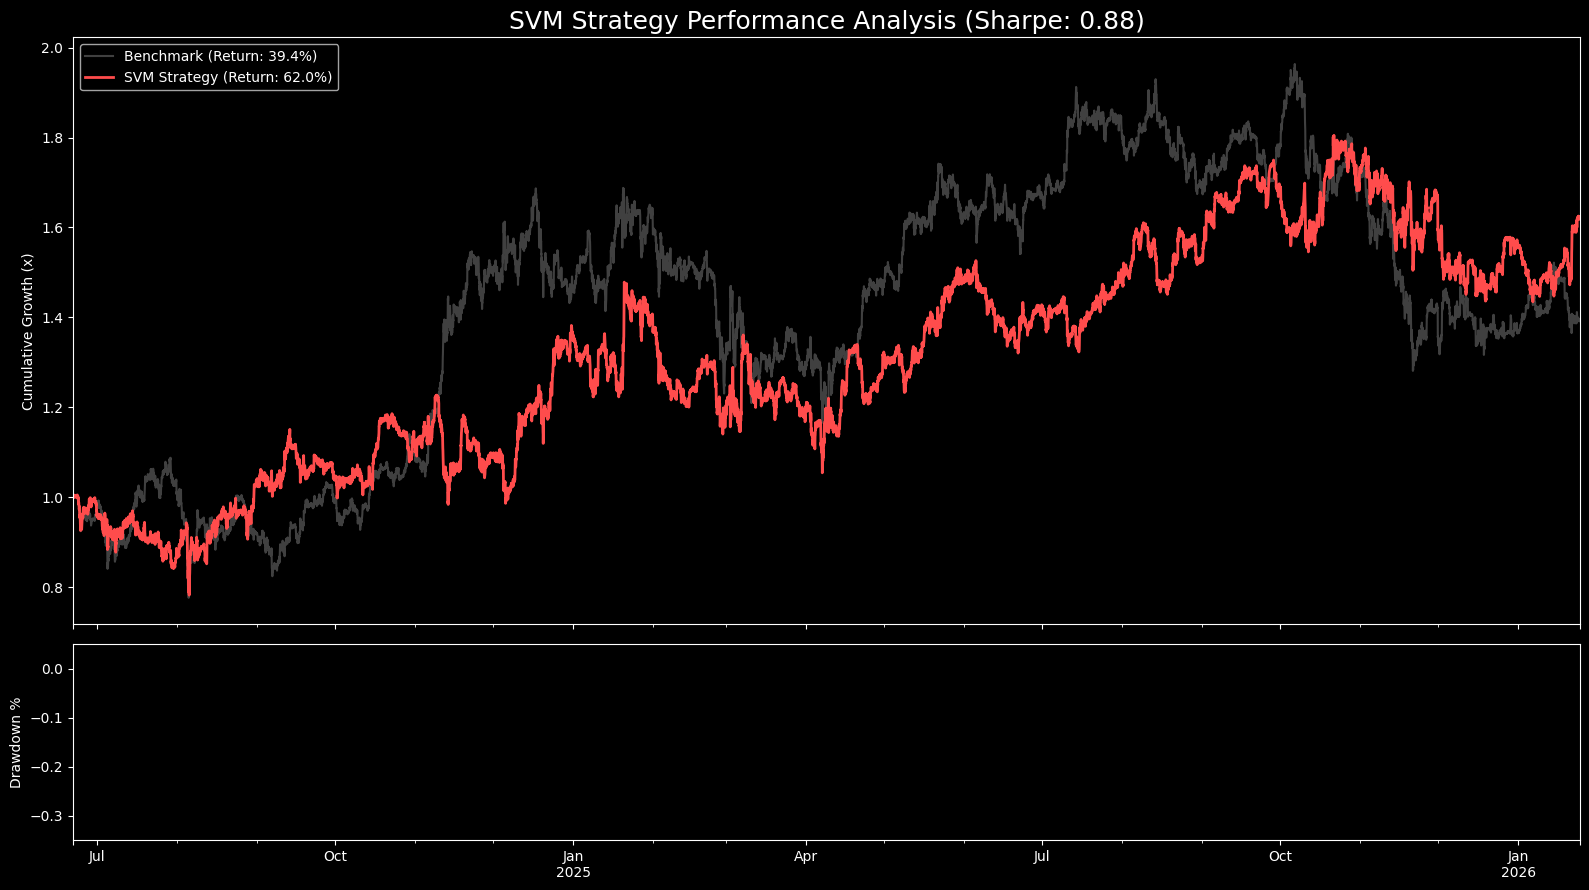


--- Strategy Performance Comparison ---
         Metric Strategy Benchmark
   Total Return    62.0%     39.4%
Ann. Volatility    46.9%     46.9%
   Sharpe Ratio     0.88      0.68
   Max Drawdown   -28.7%    -34.8%


In [7]:
def calculate_metrics(returns):
    sharpe = (returns.mean() / returns.std()) * np.sqrt(24 * 365) if returns.std() != 0 else 0
    cum_ret = (1 + returns).cumprod()
    drawdown = cum_ret / cum_ret.cummax() - 1
    max_dd = drawdown.min()
    vol = returns.std() * np.sqrt(24 * 365)
    return sharpe, max_dd, vol, cum_ret.iloc[-1] - 1


def run_professional_backtest(y_test, y_pred, df_full):

    # Extract test period
    test_period = df_full.iloc[-len(y_test):].copy()

    # Signal processing
    test_period['signal'] = np.where(y_pred == 1, 1, -1)
    test_period['strat_ret'] = test_period['signal'].shift(1) * test_period['returns']

    # Clean NaNs
    test_period = test_period.dropna()

    # Metrics
    s_sharpe, s_mdd, s_vol, s_ret = calculate_metrics(test_period['strat_ret'])
    b_sharpe, b_mdd, b_vol, b_ret = calculate_metrics(test_period['returns'])

    # Visualization
    fig, (ax1, ax2) = plt.subplots(
        2, 1, sharex=True, gridspec_kw={'height_ratios': [3, 1]}
    )

    # Equity curves
    ((1 + test_period['returns']).cumprod()).plot(
        ax=ax1, label=f'Benchmark (Return: {b_ret:.1%})', color='gray', alpha=0.5
    )

    ((1 + test_period['strat_ret']).cumprod()).plot(
        ax=ax1, label=f'SVM Strategy (Return: {s_ret:.1%})',
        color=COLORS[2], linewidth=2
    )

    ax1.set_title(
        f'SVM Strategy Performance Analysis (Sharpe: {s_sharpe:.2f})',
        fontsize=18
    )
    ax1.legend(loc='upper left')
    ax1.set_ylabel('Cumulative Growth (x)')

    # Drawdown
    dd = (1 + test_period['strat_ret']).cumprod()
    dd = dd / dd.cummax() - 1

    ax2.fill_between(dd.index, dd, 0, alpha=0.3)
    ax2.set_ylabel('Drawdown %')
    ax2.set_ylim(-0.35, 0.05)

    plt.tight_layout()
    plt.show()

    # Performance table
    stats = pd.DataFrame({
        'Metric': ['Total Return', 'Ann. Volatility', 'Sharpe Ratio', 'Max Drawdown'],
        'Strategy': [f"{s_ret:.1%}", f"{s_vol:.1%}", f"{s_sharpe:.2f}", f"{s_mdd:.1%}"],
        'Benchmark': [f"{b_ret:.1%}", f"{b_vol:.1%}", f"{b_sharpe:.2f}", f"{b_mdd:.1%}"]
    })

    print("\n--- Strategy Performance Comparison ---")
    print(stats.to_string(index=False))


# Run
run_professional_backtest(y_test, y_pred, df)


---
## 6. Persistence & Deployment
Exporting the optimized artifacts for live trading simulation.

In [8]:
# ==============================
# 7. Save Model & Scaler
# ==============================
# Make sure the folder exists
os.makedirs(os.path.dirname(MODEL_SAVE_PATH), exist_ok=True)
os.makedirs(os.path.dirname(SCALER_SAVE_PATH), exist_ok=True)

# Save the SVM model
joblib.dump(best_svm, MODEL_SAVE_PATH)

# Save the scaler
joblib.dump(scaler, SCALER_SAVE_PATH)

print(f"✅ SVM model successfully saved in: {MODEL_SAVE_PATH}")
print(f"✅ Scaler successfully saved in: {SCALER_SAVE_PATH}")
print(f"✅ Model trained with {len(X_train)} training samples")
print(f"✅ Best parameters: {grid_search.best_params_}")
print(f"✅ Final accuracy: {acc:.2%}")


✅ SVM model successfully saved in: ../models/svm/best_svm_model.pkl
✅ Scaler successfully saved in: ../models/svm/best_scaler_svm.pkl
✅ Model trained with 55888 training samples
✅ Best parameters: {'C': 0.1, 'gamma': 0.01}
✅ Final accuracy: 52.61%


In [ ]:
import json
from datetime import datetime

metadata = {
    "model_name": "SVM Bitcoin Directional Predictor",
    "model_type": "Support Vector Machine (RBF Kernel)",
    "accuracy": float(acc), 
    "best_params": grid_search.best_params_,
    "top_features": top_features[:35],  
    "feature_selection_method": "SelectKBest (f_classif) + Correlation Filter",
    "training_size": len(X_train),
    "test_size": len(X_test),
    "total_dataset_size": len(df),
    "timeframe": "Hourly",
    "target_variable": "target_direction",
    "hyperparameter_search_space": param_grid,
    "cv_method": "TimeSeriesSplit (n_splits=3)",
    "optimization_samples": 10000,
    "final_training_samples": 20000,
    "data_preprocessing": {
        "scaling": "StandardScaler",
        "missing_values": "forward/backward fill",
        "lag_features": "1-5 lags for key indicators"
    },
    "performance_metrics": {
        "accuracy": float(acc),
        "classification_report": classification_report(y_test, y_pred, output_dict=True)
    },
    "export_timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "model_files": {
        "model_path": MODEL_SAVE_PATH,
        "scaler_path": SCALER_SAVE_PATH,
        "metadata_path": "../models/svm/svm_model_metadata.json"
    }
}

METADATA_SAVE_PATH = "../models/svm/svm_model_metadata.json"
os.makedirs(os.path.dirname(METADATA_SAVE_PATH), exist_ok=True)

with open(METADATA_SAVE_PATH, 'w') as f:
    json.dump(metadata, f, indent=4, default=str)

print(f"✅ Metadata successfully saved in: {METADATA_SAVE_PATH}")
print("\n📊 Summary of the metadata:")
print(f"   Model name: {metadata['model_name']}")
print(f"   Accuracy: {metadata['accuracy']:.2%}")
print(f"   Best parameters: {metadata['best_params']}")
print(f"   Number of features: {len(metadata['top_features'])}")
print(f"   Training set size: {metadata['training_size']}")
print(f"   Test set size: {metadata['test_size']}")
print(f"   Export timestamp: {metadata['export_timestamp']}")

print("\n📋 Preview of the metadata JSON:")
print(json.dumps({k: metadata[k] for k in ['model_name', 'accuracy', 'best_params', 'training_size', 'test_size']}, indent=2))

✅ Metadata successfully saved in: ../models/svm/svm_model_metadata.json

📊 Summary of the metadata:
   Model name: SVM Bitcoin Directional Predictor
   Accuracy: 52.61%
   Best parameters: {'C': 0.1, 'gamma': 0.01}
   Number of features: 25
   Training set size: 55888
   Test set size: 13973
   Export timestamp: 2026-02-04 22:38:37

📋 Preview of the metadata JSON:
{
  "model_name": "SVM Bitcoin Directional Predictor",
  "accuracy": 0.5260860230444429,
  "best_params": {
    "C": 0.1,
    "gamma": 0.01
  },
  "training_size": 55888,
  "test_size": 13973
}
